In [21]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
%matplotlib inline
import matplotlib
import requests
from pandas.io.json import json_normalize 
import time 
import csv
import os
from pprint import pprint
import ipywidgets as widgets
from IPython.display import display

import seaborn as sns


-------------------------------------------------------------------------------------------------------------------------------
Pie Chart Representation - Global Percentage
---------------------------------------------------------------------------

C:\Users\shweta shukla\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


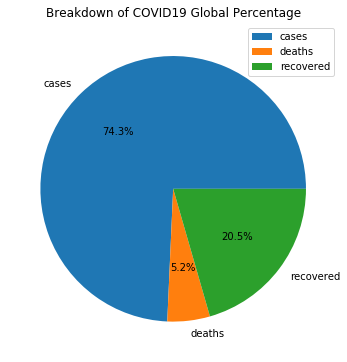

In [22]:
global_url = "https://coronavirus-19-api.herokuapp.com/all"
response_global_url = requests.get(global_url)
global_df = json_normalize(response_global_url.json(), errors='ignore')
global_df

Global_DF = pd.DataFrame(global_df)
Global_DF

# Filter the DataFrame down only to those columns to chart
pie_chart = Global_DF[["cases","deaths","recovered"]]

# Labels for the sections of our pie chart
labels = ["cases", "deaths", "recovered"]

# The values of each section of the pie chart
sizes = pie_chart

# Creates the pie chart based upon the values above, save and display it
fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(sizes,labels = labels, autopct='%1.1f%%')
plt.tight_layout()
plt.title("Breakdown of COVID19 Global Percentage")
plt.legend( loc = 'upper right' )
plt.savefig("PNG Folder/COVID19 Global Percentage of Cases")


The spread of COVID19 is worldwide owing to its large percentage.

-------------------------------------------------------------------------------------------------------------------------------
Pie Chart Representation - Countrywise Stats - Cases, Deaths, Recovered
--------------------------------------------------------------------------------------------------------------------

In [23]:
# uploading cases/deaths by country and formatting dataframe
countries_url = "https://coronavirus-19-api.herokuapp.com/countries"
response2 = requests.get(countries_url)
Countries_df = json_normalize(response2.json(), errors='ignore')
Countries_df = Countries_df.iloc[Countries_df.index>7,[0,1,2,3,4,5,6,7]]
Countries_df = Countries_df[Countries_df["country"] != "Total:"]
Countries_df.loc[8,"country"]='United States'
Countries_df
#imported data on SES and created a dataframe
globses = pd.read_csv("CSV Folder/GLOB.csv", encoding = 'latin-1')
globses = globses[globses["year"]==2010]
globses = globses.reset_index(drop = True)

#merged ses data with countries Covid Data
combined_Countries_df_data = pd.merge(Countries_df, globses, how="left", on=["country", "country"])  
combined_Countries_df_data.dropna(inplace =True) 
combined_Countries_df_data.reset_index(inplace = True, drop = True) 

#Clean up column header names
combined_Countries_df_data.rename(columns = {"country":"Country",
                           "cases":"Total Cases",
                           "todayCases":"Cases Today",
                           "deaths": "Deaths",
                           "todayDeaths":"Deaths Today",
                           "recovered":"Total Recovered",
                           "active":"Active Cases",
                           "critical": "Critical",
                           "gdppc": "GDP per Capita",
                           "yrseduc":"Avg Years Education"}, inplace = True)

#read in government type file and inner merge on country
gov_df = pd.read_csv("CSV Folder/Gov_type.csv")
combined_Countries_df_data2 = combined_Countries_df_data.merge(gov_df, how="inner", on="Country") 
combined_Countries_df_data2

,Country,Total Cases,Cases Today,Deaths,Deaths Today,Total Recovered,Active Cases,Critical,unid,wbid,year,SES,GDP per Capita,Avg Years Education,popshare,Government Type
0,United States,923612,37170,52092,1858,93404.0,778116,14954,840.0,USA,2010.0,97.464378,49372.8320,13.0971,0.045907,constitutional federal republic
1,Spain,219764,6740,22524,367,92355.0,104885,7705,724.0,ESP,2010.0,85.359718,32506.4340,10.3821,0.006912,parliamentary constitutional monarchy
2,Italy,192994,3021,25969,420,60498.0,106527,2173,380.0,ITA,2010.0,85.016357,36201.1600,9.5096,0.008797,parliamentary republic
3,France,159828,1645,22245,389,43493.0,94090,4870,250.0,FRA,2010.0,88.194969,36872.2270,10.5329,0.009650,semi-presidential republic
4,Germany,154999,1870,5760,185,106800.0,42439,2908,276.0,DEU,2010.0,92.546394,40428.7230,11.8231,0.012136,federal parliamentary republic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Benin,54,0,1,0,27.0,26,0,204.0,BEN,2010.0,5.954444,1759.3870,4.2168,0.001411,presidential republic
66,Syria,42,0,3,0,6.0,33,0,760.0,SYR,2010.0,37.778469,9227.2402,5.2782,0.003075,presidential republic; highly authoritarian re...
67,Malawi,33,0,3,0,4.0,26,1,454.0,MWI,2010.0,5.964601,1060.7469,4.7003,0.002192,presidential republic
68,Angola,25,0,2,0,6.0,17,0,24.0,AGO,2010.0,21.247763,6492.1768,2.7900,0.003149,presidential republic


In [24]:
CasesbyCountry = Countries_df.loc[:,["country","cases"]]
CasesbyCountry.sort_values("cases", ascending = False,inplace = True)
CasesbyCountry

,country,cases
8,United States,923612
9,Spain,219764
10,Italy,192994
11,France,159828
12,Germany,154999
...,...,...
214,South Sudan,5
215,Sao Tome and Principe,4
216,Anguilla,3
217,Saint Pierre Miquelon,1


2826673


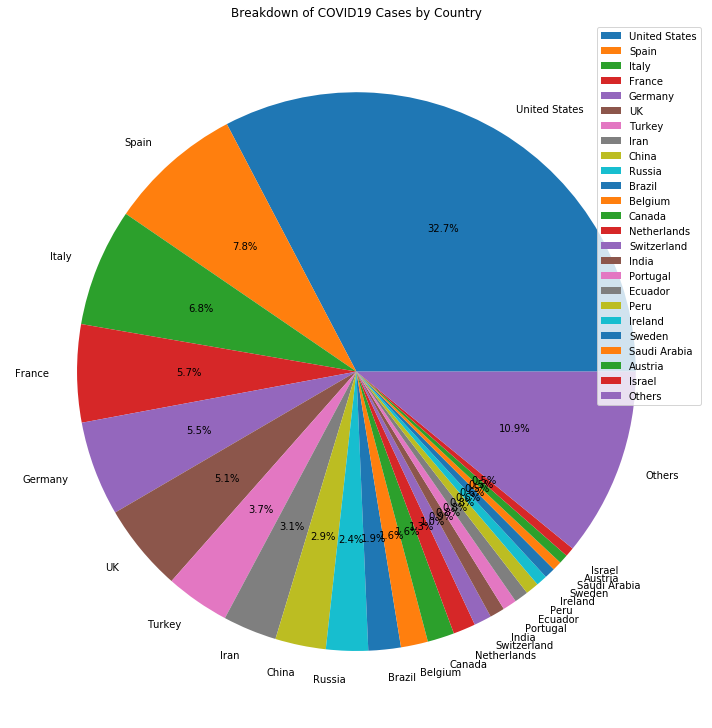

In [25]:
CasesbyCountry = Countries_df.loc[:,["country","cases"]]
CasesbyCountry.sort_values("cases", ascending = False,inplace = True)
CasesbyCountry["Percent of Cases World"]=round(CasesbyCountry["cases"]/(CasesbyCountry["cases"].sum())*100,2)
CasesbyCountry.reset_index(drop = True)
CountryCases =CasesbyCountry ["cases"].sum()
print(CountryCases)
CountryCasesPie = CasesbyCountry[CasesbyCountry["Percent of Cases World"]>.5]
PercentTop = CountryCasesPie["Percent of Cases World"].sum()
PercentOther = (100 - float(PercentTop))
OtherCases = CountryCases - CountryCasesPie["cases"].sum()
Chart = CountryCasesPie.append({"country":"Others","cases":OtherCases,"Percent of Cases World":PercentOther}, ignore_index = True)
labels = Chart["country"]
sizes = Chart ["cases"]
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(sizes,labels = labels, autopct='%1.1f%%')
plt.tight_layout()
plt.title("Breakdown of COVID19 Cases by Country")
plt.legend( loc = 'upper right' )
plt.savefig("PNG Folder/COVID19 Cases by Country.png")


In [26]:
OtherCases = CountryCases - CountryCasesPie["Percent of Cases World"].sum()
print(CountryCasesPie["Percent of Cases World"].sum())
print(OtherCases)
print(f" Total Cases in World are {CountryCases} and the percent of countries with less than 1% is {PercentOther}")

89.05000000000001
2826583.95
 Total Cases in World are 2826673 and the percent of states with less than 1% is 10.949999999999989


INFERENCES-
United States has the highest no. of cases, followed by Spain and Italy.
Also, Total Cases in World are2658794 and the percent of countries with less than 1% is 11.830000000000027.

In [27]:
CasesbyCountry = Countries_df.loc[:,["country","deaths"]]
CasesbyCountry.sort_values("deaths", ascending = False,inplace = True)
CasesbyCountry

,country,deaths
8,United States,52092
10,Italy,25969
9,Spain,22524
11,France,22245
13,UK,19506
...,...,...
187,New Caledonia,0
189,CAR,0
190,Dominica,0
191,Namibia,0


196972


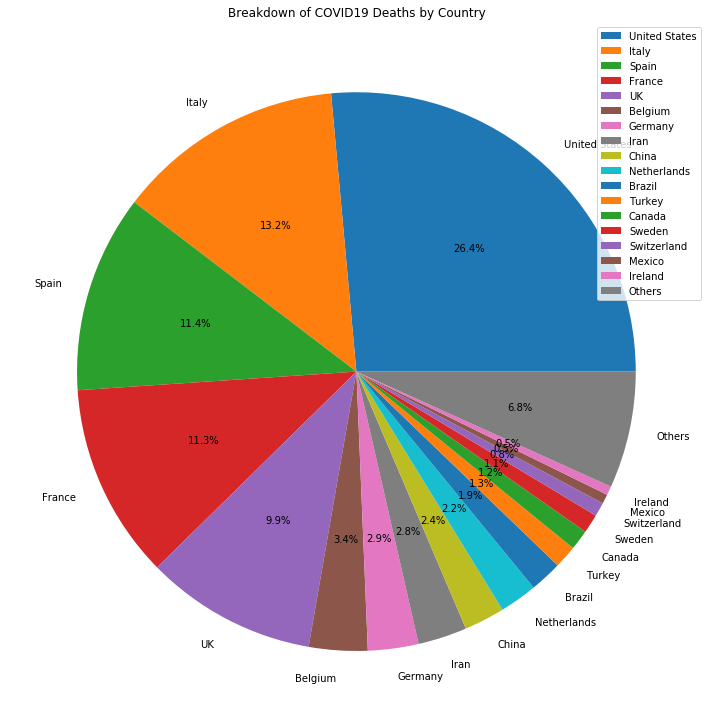

In [28]:
CasesbyCountry = Countries_df.loc[:,["country","deaths"]]
CasesbyCountry.sort_values("deaths", ascending = False,inplace = True)
CasesbyCountry["Percent of Deaths World"]=round(CasesbyCountry["deaths"]/(CasesbyCountry["deaths"].sum())*100,2)
CasesbyCountry.reset_index(drop = True)
CountryCases =CasesbyCountry ["deaths"].sum()
print(CountryCases)
CountryCasesPie = CasesbyCountry[CasesbyCountry["Percent of Deaths World"]>.5]
PercentTop = CountryCasesPie["Percent of Deaths World"].sum()
PercentOther = (100 - float(PercentTop))
OtherCases = CountryCases - CountryCasesPie["deaths"].sum()
Chart = CountryCasesPie.append({"country":"Others","deaths":OtherCases,"Percent of Deaths World":PercentOther}, ignore_index = True)
labels = Chart["country"]
sizes = Chart ["deaths"]
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(sizes,labels = labels, autopct='%1.1f%%')
plt.tight_layout()
plt.title("Breakdown of COVID19 Deaths by Country")
plt.legend( loc = 'upper right' )
plt.savefig("PNG Folder/COVID19 Deaths by Country.png")


In [29]:
OtherCases = CountryCases - CountryCasesPie["Percent of Deaths World"].sum()
print(CountryCasesPie["Percent of Deaths World"].sum())
print(OtherCases)
print(f" Total Deaths in World are {CountryCases} and the percent of countries with less than 1% is {PercentOther}")

93.23
196878.77
 Total Deaths in World are 196972 and the percent of states with less than 1% is 6.769999999999996


INFERENCES-
United States has the highest death rate, followed by Italy and Spain.
Also, Total Deaths in World are 185440 and the percent of countries with less than 1% is 7.1200000000000045.

In [30]:
CasesbyCountry = Countries_df.loc[:,["country","recovered"]]
CasesbyCountry.sort_values("recovered", ascending = False,inplace = True)
CasesbyCountry

,country,recovered
12,Germany,106800.0
8,United States,93404.0
9,Spain,92355.0
219,China,77257.0
15,Iran,66599.0
...,...,...
215,Sao Tome and Principe,0.0
217,Saint Pierre Miquelon,0.0
183,Botswana,0.0
13,UK,NaN


780659.0


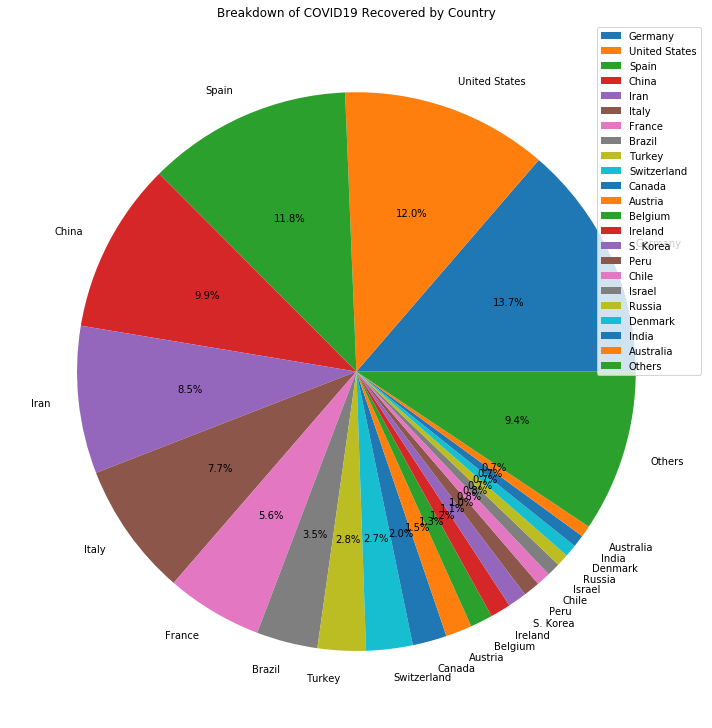

In [31]:
CasesbyCountry = Countries_df.loc[:,["country","recovered"]]
CasesbyCountry.sort_values("recovered", ascending = False,inplace = True)
CasesbyCountry["Percent of Recovered World"]=round(CasesbyCountry["recovered"]/(CasesbyCountry["recovered"].sum())*100,2)
CasesbyCountry.reset_index(drop = True)
CountryCases =CasesbyCountry ["recovered"].sum()
print(CountryCases)
CountryCasesPie = CasesbyCountry[CasesbyCountry["Percent of Recovered World"]>.5]
PercentTop = CountryCasesPie["Percent of Recovered World"].sum()
PercentOther = (100 - float(PercentTop))
OtherCases = CountryCases - CountryCasesPie["recovered"].sum()
Chart = CountryCasesPie.append({"country":"Others","recovered":OtherCases,"Percent of Recovered World":PercentOther}, ignore_index = True)
labels = Chart["country"]
sizes = Chart ["recovered"]
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(sizes,labels = labels, autopct='%1.1f%%')
plt.tight_layout()
plt.title("Breakdown of COVID19 Recovered by Country")
plt.legend( loc = 'upper right' )
plt.savefig("PNG Folder/COVID19 Recovered by Country.png")

In [32]:
OtherCases = CountryCases - CountryCasesPie["Percent of Recovered World"].sum()
print(CountryCasesPie["Percent of Recovered World"].sum())
print(OtherCases)
print(f" Total Recovered in World are {CountryCases} and the percent of countries with less than 1% is {PercentOther}")

90.61999999999999
780568.38
 Total Recovered in World are 780659.0 and the percent of states with less than 1% is 9.38000000000001


INFERENCES-
Germany has the highest recovered rate, followed by Spain and United States.
Also, Total Recovered in World are 729443.0 and the percent of countries with less than 1% is 8.730000000000004.

-------------------------------------------------------------------------------------------------------------------------------
Bar Chart Representation - United States Statewise - TestResults - Positive, Negative
-----------------------------------------------------------------------------------------------------------------------------

In [33]:
#read in .csv file
hospital_data = pd.read_csv("CSV Folder/hospitals.csv")
#set index to state_name
hospital_data.set_index("state_name",inplace=True)
hospital_data["num_icu_be"].fillna(0, inplace = True)
hospital_data["bed_utiliz"].fillna(0, inplace = True)
hospital_data["num_licens"].replace("****",0,inplace = True)
hospital_data["num_staffe"].replace("****",0,inplace = True)
hospital_data['num_licens']=hospital_data['num_licens'].astype(int)
hospital_data['num_staffe']=hospital_data['num_staffe'].astype(int)
#group dataframe by state_name
hg = hospital_data.groupby('state_name')
#do count of hg dataframe (where it groups by states)to get total count of hospitals, doctors, staff,
#icu beds, and icu beds utilized. Then add each series to new dataframe called 'state_hospital_data'
hg["num_icu_be"].count()
state_hospital_data = pd.DataFrame(hg["num_icu_be"].sum())
hospitals = hg["hospital_n"].count()
state_hospital_data["Number of Hospitals"]=hospitals
doctors = hg["num_licens"].sum()
state_hospital_data["Number of Doctors"]=doctors
staff = hg["num_staffe"].sum()
state_hospital_data["Number of Staff"]=staff
icu_beds = hg["num_icu_be"].sum()
state_hospital_data["ICU Beds Available"]=icu_beds
bed_utiliz = hg["bed_utiliz"].sum()
state_hospital_data["ICU Beds Utilized"]=bed_utiliz
#drop double num_icu_be column
state_hospital_data.drop("num_icu_be",axis=1, inplace = True)
state_hospital_data.head()

,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized
state_name,,,,,
Alabama,120,18628,14974,1105.0,51.338370
Alaska,28,1760,1542,106.0,8.750062
Arizona,126,17163,15379,1263.0,55.551942
Arkansas,106,12869,9990,667.0,43.539306
California,466,85161,80802,6925.0,216.716364


In [34]:
# reaching out to API to get current overall state data pertaining to cases, tests, hospitalizations, and deaths
states_url = "https://covidtracking.com/api/states"
response3 = requests.get(states_url)
#Turned entire response into a dataframe
US_df = json_normalize(response3.json(), errors='ignore')
#Narrowed df to specific columns of interest 
US_df = US_df.iloc[:,[0,1,10,11,24,18,12,21]]

#Read in a State Name Abbrev CSV so that df's could be joined with different state naming conventions
st_abrev = pd.read_csv("CSV Folder/Covid Analysis Data - StateNameAbrev.csv")

# Replacing the state abbreviation with names for joining to other data
tests_df = st_abrev.merge(US_df, how = 'inner',left_on = "Abbreviation",right_on = "state")

#Droping abbreviation column since no other dataset used abbrev.
tests_df.drop(columns = ["Abbreviation","state"],inplace = True)

#Joined hospital information with the general information
comb1_df= tests_df.merge(state_hospital_data,how = 'inner',left_on = "State",right_on = "state_name")
#comb1_df.drop(columns = "state_name", inplace = True)

#Read in file about rankings of aggressive measures limiting the virus spread
States_Most_Aggressive_Measures_df = pd.read_csv("CSV Folder/States with the Most Aggressive Measures in Limiting Virus Exposure.csv", encoding ='latin-1')

#Joined rankings data
comb2_df = comb1_df.merge(States_Most_Aggressive_Measures_df, how = 'inner', on = 'State' )

#Renamed Column Headers
comb2_df.rename(columns = {"positive":"Positive",
                           "negative":"Negative",
                           "pending":"Pending",
                           "totalTestResults": "Total Tested",
                           "recovered": "Recovered",
                           "hospitalizedCurrently":"Currently Hospitalized",
                           "death": "Total Deaths",
                           "num_icu_be":"ICU Beds",
                           "Prevention & Containment Rank": "Prevention & Containment Rank",
                           "Risk Factors & Infrastructure Rank": "Risk Factors & Infrastructure Rank",
                           "Economic Impact Rank": "Economic Impact Rank"}, inplace = True)

In [35]:
comb2_df.head()

,State,Positive,Negative,Pending,Total Tested,Recovered,Currently Hospitalized,Total Deaths,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized,Overall Rank,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,Alabama,5832,46863,NaN,52695,NaN,NaN,197.0,120,18628,14974,1105.0,51.338370,48,48,45,2,-15
1,Alaska,339,11942,NaN,12281,208.0,36.0,9.0,28,1760,1542,106.0,8.750062,3,2,11,40,11
2,Arizona,6045,54669,NaN,60714,1313.0,639.0,266.0,126,17163,15379,1263.0,55.551942,39,36,46,19,-1
3,Arkansas,2741,32837,NaN,35578,929.0,101.0,45.0,106,12869,9990,667.0,43.539306,46,45,49,5,1
4,California,39254,454919,NaN,494173,NaN,4880.0,1562.0,466,85161,80802,6925.0,216.716364,18,15,44,16,-17


In [36]:
# Filter the DataFrame down only to those columns to chart
bar_chart_df = comb2_df[["State","Positive","Negative"]]

# Set the index to be "State" so they will be used as labels
bar_chart_df = bar_chart_df.set_index("State")

bar_chart_df.head()

,Positive,Negative
State,,
Alabama,5832,46863
Alaska,339,11942
Arizona,6045,54669
Arkansas,2741,32837
California,39254,454919


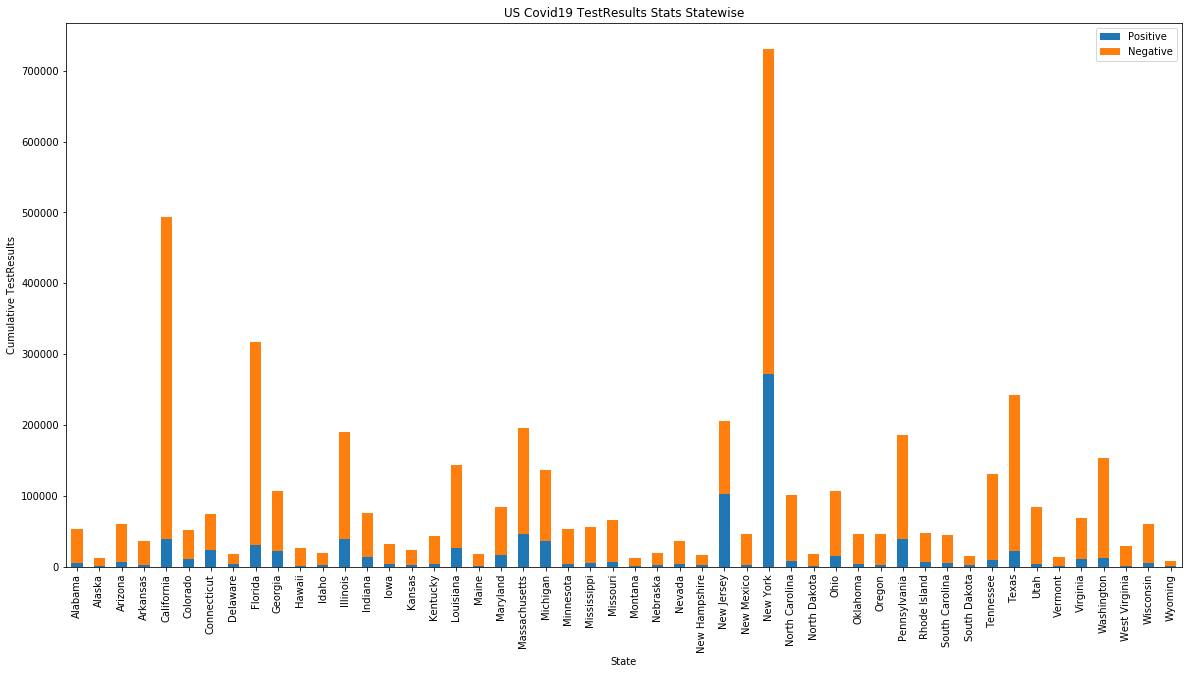

<Figure size 432x288 with 0 Axes>

In [37]:
# Use DataFrame.plot() in order to create a bar chart of the data
bar_chart_df.plot(kind="bar", figsize=(20,10), stacked=True,title = 'US Covid19 TestResults Stats Statewise')

# Display the chart
plt.ylabel("Cumulative TestResults")
plt.show()
plt.tight_layout()

# Save the bar chart
plt.savefig("PNG Folder/COVID19 Statewise TestResults Stacked Bar Chart.png")

California, New york, New Jersey, Florida, Texas are way ahead in testing compared to other states. They're also having comparable positives with respect to each other.

-------------------------------------------------------------------------------------------------------------------------------
Scatter Plot Representation - United States Statewise - TestResults vs Deaths 
-----------------------------------------------------------------------------------------------------------------

In [38]:
# Filter the DataFrame down only to those columns to chart
scatter_chart_df = comb2_df[["State","Total Tested","Total Deaths"]]

# Set the index to be "State" so they will be used as labels
scatter_chart_df = scatter_chart_df.set_index("State")

scatter_chart_df.head()

,Total Tested,Total Deaths
State,,
Alabama,52695,197.0
Alaska,12281,9.0
Arizona,60714,266.0
Arkansas,35578,45.0
California,494173,1562.0


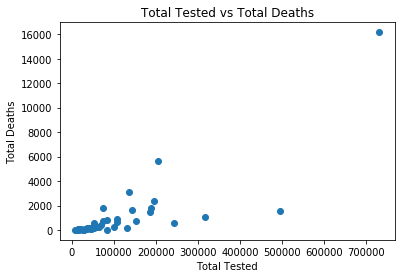

In [39]:
#scatter_plot = scatter_chart_df.groupby(['State']).mean()
plt.scatter(scatter_chart_df['Total Tested'],scatter_chart_df['Total Deaths'])
plt.title('Total Tested vs Total Deaths')
plt.xlabel('Total Tested')
plt.ylabel('Total Deaths')

plt.savefig("PNG Folder/ COVID19 Scatter Plot Total Tested vs Total Deaths.png")
plt.show()


In [40]:
#CORRELATION 
correlation=round(st.pearsonr(scatter_chart_df['Total Tested'],scatter_chart_df['Total Deaths'])[0],2)
print(f"The correlation between Total Tested and Total Deaths is {correlation}")

The correlation between Total Tested and Total Deaths is 0.81


In [41]:
#REGRESSION
linear_regression_model=st.linregress(scatter_chart_df['Total Tested'],scatter_chart_df['Total Deaths'])
linear_regression_model


LinregressResult(slope=0.015295444121204607, intercept=-574.127517900817, rvalue=0.8119602844940634, pvalue=8.369469823507571e-13, stderr=0.0015871055703066091)

The equation of the regression line is: y = 0.02x + -544.84
The r-squared is: 0.807371108037154


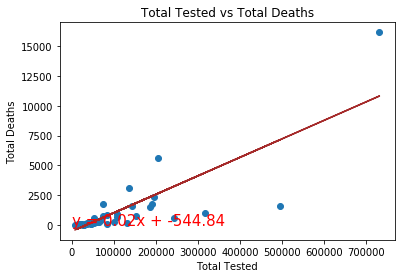

In [42]:
#Use the values of slope and intercept calculated above into the y=mx+b equation

slope=0.015544870610129788
intercept=-544.8409935520588

y = scatter_chart_df['Total Tested']*slope+intercept
plt.scatter(scatter_chart_df['Total Tested'],scatter_chart_df['Total Deaths'])
plt.plot(scatter_chart_df['Total Tested'],y,color="brown")
plt.xlabel('Total Tested')
plt.ylabel('Total Deaths')

line_equation = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
plt.annotate(line_equation,(20,20),fontsize=15,color="red")


print(f"The equation of the regression line is: {line_equation}")
print(f"The r-squared is: 0.807371108037154")
plt.title('Total Tested vs Total Deaths')
plt.savefig("PNG Folder/COVID19 Linear Regression Total Tested vs Total Deaths.png")
plt.show()

The correlation between Total Tested and Total Deaths is 0.81, which is very strong. This relationship implies - Test shortages could lead to uncounted deaths. Death reasons could be misclassified in the absence of test results.

-------------------------------------------------------------------------------------------------------------------------------
Heatmap representation - Today Cases by Country
--------------------------------------------------------------------------

In [43]:
# uploading cases/deaths by country and formatting dataframe
countries_url = "https://coronavirus-19-api.herokuapp.com/countries"
response2 = requests.get(countries_url)
Countries_df = json_normalize(response2.json(), errors='ignore')
Countries_df = Countries_df.iloc[Countries_df.index>7,[0,1,2,3,4,5,6,7]] 
Countries_df = Countries_df[Countries_df["country"] != "Total:"]
Countries_df.loc[8,"country"]='United States'
Countries_df
#imported data on SES and created a dataframe
globses = pd.read_csv("CSV Folder/GLOB.csv", encoding = 'latin-1')
globses = globses[globses["year"]==2010]
globses = globses.reset_index(drop = True)

#merged ses data with countries Covid Data
combined_Countries_df_data = pd.merge(Countries_df, globses, how="left", on=["country", "country"])  
combined_Countries_df_data.dropna(inplace =True) 
combined_Countries_df_data.reset_index(inplace = True, drop = True) 

#Clean up column header names
combined_Countries_df_data.rename(columns = {"country":"Country",
                           "cases":"Total Cases",
                           "todayCases":"Cases Today",
                           "deaths": "Deaths",
                           "todayDeaths":"Deaths Today",
                           "recovered":"Total Recovered",
                           "active":"Active Cases",
                           "critical": "Critical",
                           "gdppc": "GDP per Capita",
                           "yrseduc":"Avg Years Education"}, inplace = True)

#read in government type file and inner merge on country
gov_df = pd.read_csv("CSV Folder/Gov_type.csv")
combined_Countries_df_data2 = combined_Countries_df_data.merge(gov_df, how="inner", on="Country") 
combined_Countries_df_data2

,Country,Total Cases,Cases Today,Deaths,Deaths Today,Total Recovered,Active Cases,Critical,unid,wbid,year,SES,GDP per Capita,Avg Years Education,popshare,Government Type
0,United States,923612,37170,52092,1858,93404.0,778116,14954,840.0,USA,2010.0,97.464378,49372.8320,13.0971,0.045907,constitutional federal republic
1,Spain,219764,6740,22524,367,92355.0,104885,7705,724.0,ESP,2010.0,85.359718,32506.4340,10.3821,0.006912,parliamentary constitutional monarchy
2,Italy,192994,3021,25969,420,60498.0,106527,2173,380.0,ITA,2010.0,85.016357,36201.1600,9.5096,0.008797,parliamentary republic
3,France,159828,1645,22245,389,43493.0,94090,4870,250.0,FRA,2010.0,88.194969,36872.2270,10.5329,0.009650,semi-presidential republic
4,Germany,154999,1870,5760,185,106800.0,42439,2908,276.0,DEU,2010.0,92.546394,40428.7230,11.8231,0.012136,federal parliamentary republic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Benin,54,0,1,0,27.0,26,0,204.0,BEN,2010.0,5.954444,1759.3870,4.2168,0.001411,presidential republic
66,Syria,42,0,3,0,6.0,33,0,760.0,SYR,2010.0,37.778469,9227.2402,5.2782,0.003075,presidential republic; highly authoritarian re...
67,Malawi,33,0,3,0,4.0,26,1,454.0,MWI,2010.0,5.964601,1060.7469,4.7003,0.002192,presidential republic
68,Angola,25,0,2,0,6.0,17,0,24.0,AGO,2010.0,21.247763,6492.1768,2.7900,0.003149,presidential republic


In [44]:
# Filter the DataFrame down only to those columns to chart
heatmap_df = combined_Countries_df_data2[["Country","Cases Today"]]

heatmap_df.head()

,Country,Cases Today
0,United States,37170
1,Spain,6740
2,Italy,3021
3,France,1645
4,Germany,1870


In [45]:
# pandas pivot
heatmap1_data = pd.pivot_table(heatmap_df, values='Cases Today', 
                     index=['Country'], 
                              )

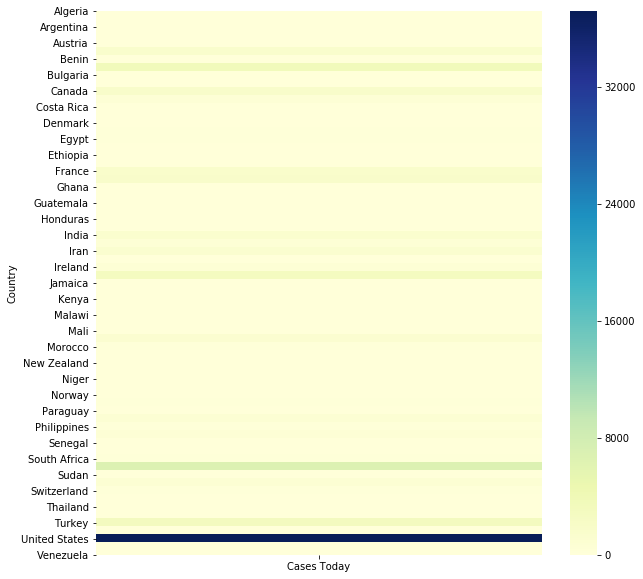

In [46]:
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap1_data, cmap="YlGnBu")

In [47]:
plt.savefig("PNG Folder/COVID19 Heatmap Cases Today.png")

<Figure size 432x288 with 0 Axes>